In [95]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from scipy.special import gammainc
from scipy.optimize import curve_fit

In [96]:
from src.HBTReader import HBTReader
from src import read
from src import cosmology
from src import nfw
from src import einasto

matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

### Analysis parameters

In [97]:
grav = "GR_b64n512"
prof = "nfw"
snap = 122
nbins = 20
bin = 10

r = HBTReader("./data/%s/subcat" % grav)

### Subhalo mass function

In [4]:
def subhalo_mass_function(r, snap):
    ss = r.LoadSubhalos(snap)
    ss = ss[(ss['HostHaloId'] != -1) & (ss['BoundM200Crit'] > 0.0)& (ss['Nbound'] >= 20)]

    counts, bin_edges = np.histogram(np.log10(ss['Nbound']), 20)
    ss = np.lib.recfunctions.append_fields(ss, 'bin',\
        np.digitize(np.log10(ss['BoundM200Crit']), bin_edges),\
        usemask=False)
    bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
    return bins, np.log10(counts)

subhalo_mass_function(r, snap)

(array([ 1.42597006,  1.67585017,  1.92573029,  2.17561041,  2.42549053,
         2.67537065,  2.92525077,  3.17513089,  3.42501101,  3.67489113,
         3.92477125,  4.17465137,  4.42453149,  4.67441161,  4.92429173,
         5.17417184,  5.42405196,  5.67393208,  5.9238122 ,  6.17369232]),
 array([ 4.46188853,  4.41649072,  4.32358208,  4.17222334,  3.99563519,
         3.78689333,  3.56466606,  3.3588862 ,  3.11394335,  2.89320675,
         2.66558099,  2.42324587,  2.23552845,  1.87506126,  1.69019608,
         1.49136169,  1.04139269,  0.90308999,  0.47712125,  0.60205999]))

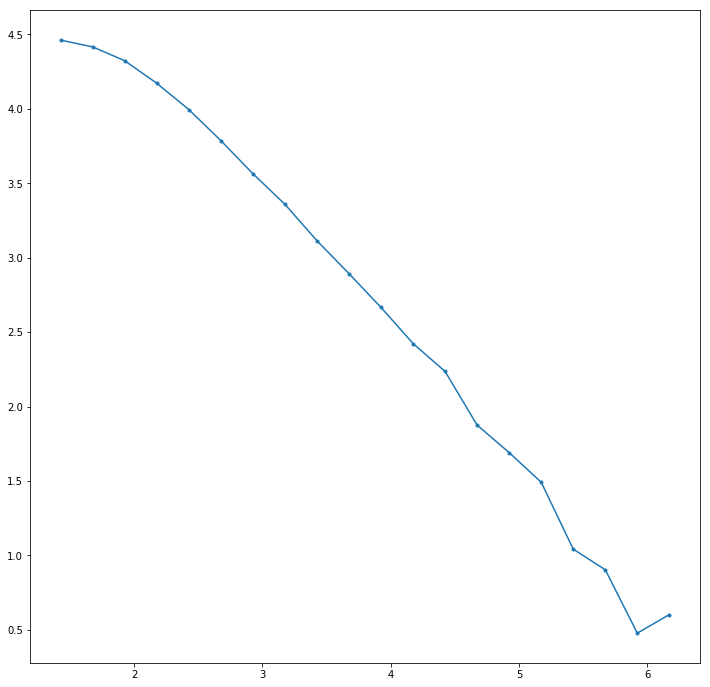

In [5]:
plt.plot(*subhalo_mass_function(r, snap), color='C0', marker='.')

### Halo mass function

Create a histogram to contain all FoF haloes, and use the bins to digitize the `M200Crit` field.

In [98]:
def read_haloes(r, snap):
    hs = r.LoadHostHalos(snap)[['HaloId','R200CritComoving','M200Crit','CenterOffset']]
    hs = hs[(hs['M200Crit'] >= 20) & (hs['CenterOffset'] >= 0.1)]
    hs['M200Crit'] = 1e10*hs['M200Crit']
    return hs
    
def bin_haloes(haloes, bin_column, bin_edges):
    hs = np.lib.recfunctions.append_fields(haloes, 'bin',\
        np.digitize(np.log10(haloes[bin_column]), bin_edges),\
        usemask=False)
    return hs

In [99]:
def halo_mass_function(r, snap):
    hs = read_haloes(r, snap)
    counts, bin_edges = np.histogram(np.log10(hs['M200Crit']), nbins)
    hs = bin_haloes(hs, 'M200Crit', bin_edges)
    bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
    return bins, np.log10(counts)

halo_mass_function(r, snap)

(array([ 11.35265238,  11.43809936,  11.52354634,  11.60899332,
         11.69444029,  11.77988727,  11.86533425,  11.95078123,
         12.0362282 ,  12.12167518,  12.20712216,  12.29256914,
         12.37801611,  12.46346309,  12.54891007,  12.63435705,
         12.71980402,  12.805251  ,  12.89069798,  12.97614496]),
 array([ 4.10649687,  4.22419627,  4.15739632,  4.01025754,  3.81604234,
         3.58353882,  3.34242268,  3.12839927,  2.92376196,  2.71683772,
         2.46982202,  2.32221929,  2.06445799,  1.79934055,  1.60205999,
         1.38021124,  0.95424251,  0.77815125,  0.69897   ,  0.47712125]))

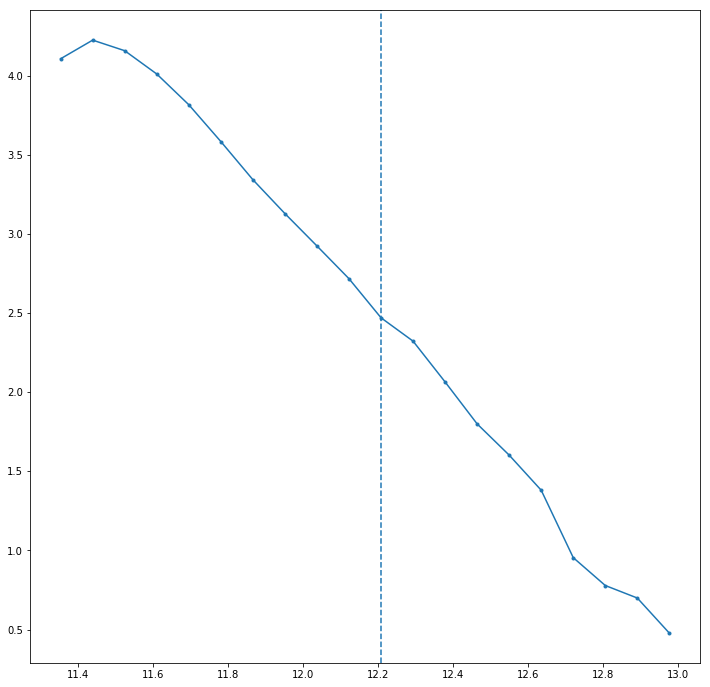

In [100]:
plt.axvline(halo_mass_function(r, snap)[0][bin], color='C0', linestyle='--')
plt.plot(*halo_mass_function(r, snap), color='C0', marker='.')

### Concentration - mass relation

In [101]:
hs = read_haloes(r, snap)
_, bin_edges = np.histogram(np.log10(hs['M200Crit']), nbins)
hs = bin_haloes(hs, 'M200Crit', bin_edges)
hs = hs[hs['bin'] == bin]

### Density profile

In [68]:
def f(x, c):
    return np.log10(nfw.m(np.power(10.0, x), c))

In [12]:
def halo_profiles_individual(r, hs, snap):
    ps = r.GetHostProfile([list(hs['HaloId']),], snap)
    xmin = 0.5*np.cbrt((4.0*np.pi)/(3.0*np.sum(np.mean(ps, axis=0))))
    ps = np.divide(ps.T, np.sum(ps, axis=1)).T
    x = np.linspace(-2.0, 0.0, 20)
    xmax = 0.8
    idx = np.where((np.power(10,x) < xmax) & (np.power(10,x) > xmin))
    c = np.median([fit(x[idx], p[idx], prof)[0] for p in ps])
    return c

c_individual = halo_profiles_individual(r, hs, snap)

In [138]:
def halo_profiles(r, hs, snap, prof):
    ps = r.GetHostProfile([list(hs['HaloId']),], snap)
    xmin = 0.5*np.cbrt((4.0*np.pi)/(3.0*np.sum(np.mean(ps, axis=0))))
    ps = np.divide(ps.T, np.sum(ps, axis=1)).T
    p = np.median(ps, axis=0)
    x = np.linspace(-2.0, 0.0, 20)
    # vol = np.diff(np.power(np.append([0.0], np.power(10.0, x)), 3.0))
    xmax = 0.8
    idx = np.where((np.power(10,x) < xmax) & (np.power(10,x) > xmin))

    if prof == 'nfw':
        c = curve_fit(f, x, np.log10(p))[0][0]
        rho_s = np.log10(nfw.rho_enc(1.0/c, c))
        return ps, x, p, idx, rho_s, c
    elif prof == 'einasto':
        c, a, chi2 = fit(x[idx], p[idx], prof)
        rho_s = np.log10(einasto.rho_enc(1.0/c, c, a))
        return ps, x, p, idx, rho_s, c, a, chi2
    else:
        raise ValueError("Profile must be either 'nfw' or 'einasto'")

ps, x, p, idx, rho_s, c = halo_profiles(r, hs, snap, prof)

# TODO

fitting bugs out because the fake `m_diff` uptick pulls it upwards.  new NFW function / better `f` lambda?

/cosma/local/Python/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


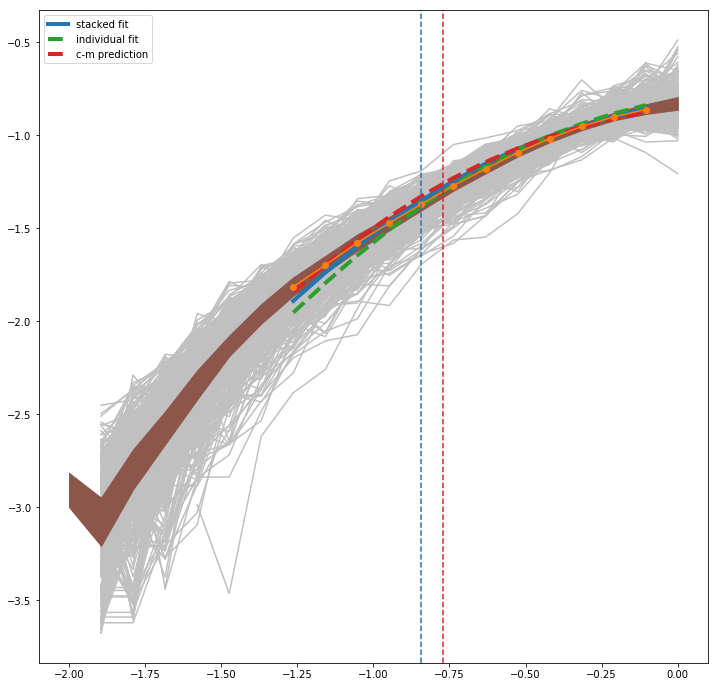

In [141]:
def plot_halo_profiles(ax, profile, *args):
    if profile == 'nfw':
        ps, x, p, idx, rho_s, c = args
    elif profile == 'einasto':
        ps, x, p, idx, rho_s, c, a = args
    else:
        raise ValueError("Profile must be either 'nfw' or 'einasto'")
        
    s1 = np.percentile(ps, 32.0, axis=0)
    s2 = np.percentile(ps, 68.0, axis=0)
    
    ax.fill_between(x, np.log10(s1), np.log10(s2), color='C5')

    ax.plot(x[idx], np.log10(nfw.m(np.power(10.,x), c)[idx]),
        color='C0', linestyle='-', linewidth=4, zorder=2, label='stacked fit')
    
    ax.plot(x[idx], np.log10(nfw.m(np.power(10.,x), c_individual)[idx]),
        color='C2',  linestyle='--',linewidth=4, zorder=2, label='individual fit')

    ax.plot(x[idx], np.log10(nfw.m(np.power(10.,x), 7.943282347242816)[idx]),
        color='C3', linestyle='--', linewidth=4, zorder=2, label='c-m prediction')

    [ax.plot(x[1:], np.log10(_[1:]), color='silver', zorder=0) for _ in ps]
    ax.plot(x[idx], np.log10(p[idx]), color='C1', marker='o', zorder=2)
    ax.axvline(np.log10(1.0/c), color='C0', linestyle='--')
    ax.axvline(np.log10(1.0/c_individual), color='C3', linestyle='--')
    
    
    ax.legend()

fig, ax = plt.subplots(1)
plot_halo_profiles(ax, prof, *halo_profiles(r, hs, snap, prof))

### Collapsed Mass History

In [16]:
def F(profile, *args):
    if profile == 'nfw':
        c = args[0]
        return nfw.m_enc(1.0/c, c)
    elif profile == 'einasto':
        c, a = args
        return einasto.m_enc(1.0/c, c, a)
    else:
        raise ValueError("Profile must be either 'nfw' or 'einasto'")

In [17]:
def halo_mass_history(grav, snap, hs, F):
    ms = np.array(read.cmh(grav, snap).loc[hs['HaloId']], dtype=np.float)
    ms = np.divide(ms.T, ms[:,-1]).T
    m = np.mean(ms, axis=0)

    zs = read.snaps()
    rho = cosmology.rho_c(
        np.array([zs[zs['Snapshot'] == s][0]['Redshift']
        for s in np.arange(1+snap-ms.shape[1], 1+snap)])) / \
        cosmology.rho_c(zs[zs['Snapshot'] == snap][0]['Redshift'])

    m_f = F*m[-1]
    y1, y2 = m[m > m_f][0], m[m < m_f][-1]
    x1, x2 = rho[m > m_f][0], rho[m < m_f][-1]
    rho_f = (np.log10(x1/x2)/np.log10(y1/y2))*(np.log10(m_f/y1))+np.log10(x1)

    return ms, rho, m, rho_f

ms, rho, m, rho_f = halo_mass_history(grav, snap, hs, F(prof, c))

/cosma/local/Python/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/cosma/local/Python/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


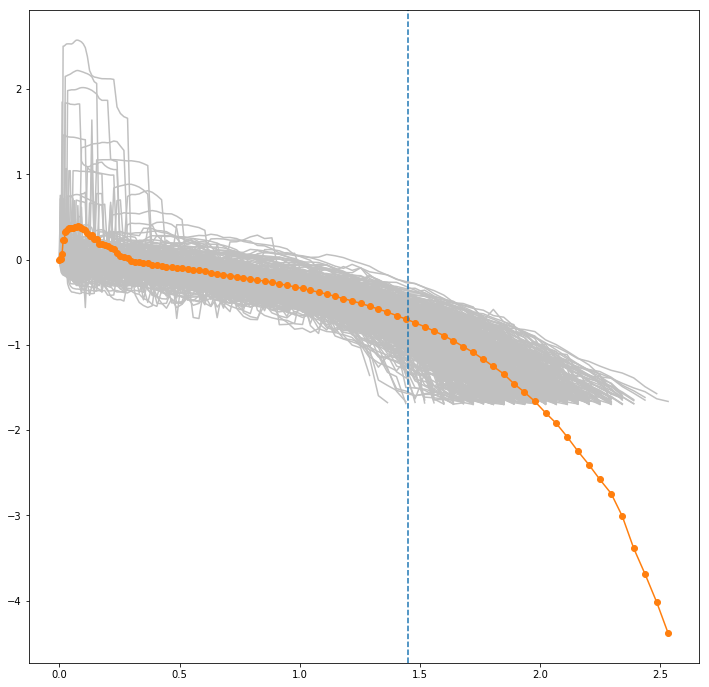

In [18]:
def plot_halo_mass_history(ax, *args):
    ms, rho, m, rho_f = args
    [ax.plot(np.log10(rho), np.log10(_), color='silver') for _ in ms]
    ax.plot(np.log10(rho), np.log10(m), color='C1', marker='o')
    ax.axvline(rho_f, color='C0', linestyle='--')

fig, ax = plt.subplots(1)
plot_halo_mass_history(ax, *halo_mass_history(grav, 122, hs, F(prof, c)))

### Density - density relation

After the analysis above has been done for all mass bins, for all snapshots, we can start plotting the density - density relation.

In [42]:
def process(hs, grav, snap, prof):
    ps = halo_profiles(HBTReader("./data/%s/subcat" % grav), hs, snap, prof)
    rho_s = ps[4]
#     _, _, _, _, rho_s, c, chi2 = halo_profiles(r, snap, prof)
#     ms, rho, m, rho_f = halo_mass_history(grav, snap, F(prof, c))
    _, _, _, rho_f = halo_mass_history(grav, snap, hs, F(prof, c))
    return grav, snap, prof, rho_f, rho_s

# process(hs, grav, snap, prof)

In [45]:
hs = read_haloes(r, 93)
_, bin_edges = np.histogram(np.log10(hs['M200Crit']), nbins)
    
for b in range(10, 15):
    ihs = bin_haloes(hs, 'M200Crit', bin_edges)
    ihs = ihs[ihs['bin'] == b]
    print(process(ihs, grav, 93, prof))

/cosma/local/Python/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/cosma/local/Python/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [33]:
# def plot(ax, ds):
#     ax.plot([0.0, 3.0], np.log10(400.0 * np.power(10.0, np.array([0.0, 3.0]))), 'k-')

#     markers = [['o', None], ['s', None], ['^', None], ['*', None], ['x', None]]
#     colours = [['C0', None], ['C1', None]]

#     for i,snap in enumerate(np.unique(ds['snap'])):
#         for j,g in enumerate(np.unique(ds['g'])):
#             for _, row in ds[(ds['snap'] == snap) & (ds['g'] == g)].iterrows():
#                 ax.scatter(
#                     row['rho_f'], row['rho_s'],
#                     color=colours[j][0],
#                     marker=markers[i][0],
#                     s=row['bin']*30,
#                     alpha=0.6
#                 )
#                 markers[i][1] = plt.Line2D([], [], label='snap %d'%snap,
#                     color='k', marker=markers[i][0], linestyle='')
#             colours[j][1] = plt.Line2D([], [], label=g,
#                 color=colours[j][0], marker='o', linestyle='')

#     ax.set_xlabel(r'$\log_{10}(\rho_{crit}(z_{form})/\rho_{crit}(z_0))$')
#     ax.set_ylabel(r'$\log_{10}(\langle\rho_{s}\rangle/\rho_{crit}(z_0))$')
#     ax.set_xlim((0.0, 2.0))
#     ax.set_ylim((2.0, 5.0))

#     l1 = ax.legend(handles=[markers[i][1] for i in range(len(markers))], loc='upper left')
#     l2 = ax.legend(handles=[colours[j][1] for j in range(len(colours))], loc='lower right')
#     ax.add_artist(l1)

In [30]:
# def read():
#     ds = pd.DataFrame()

#     for g in ['gr', 'fr']:
#         for p in ['nfw', 'einasto']:
#             _ = pd.read_csv('/gpfs/data/dc-oles1/merger_trees/output/%s/%s.csv' % (g, p))
#             _['g'] = g
#             ds = pd.concat([ds, _])

#     ds = ds.reset_index()
#     del ds['index']
    
#     return ds

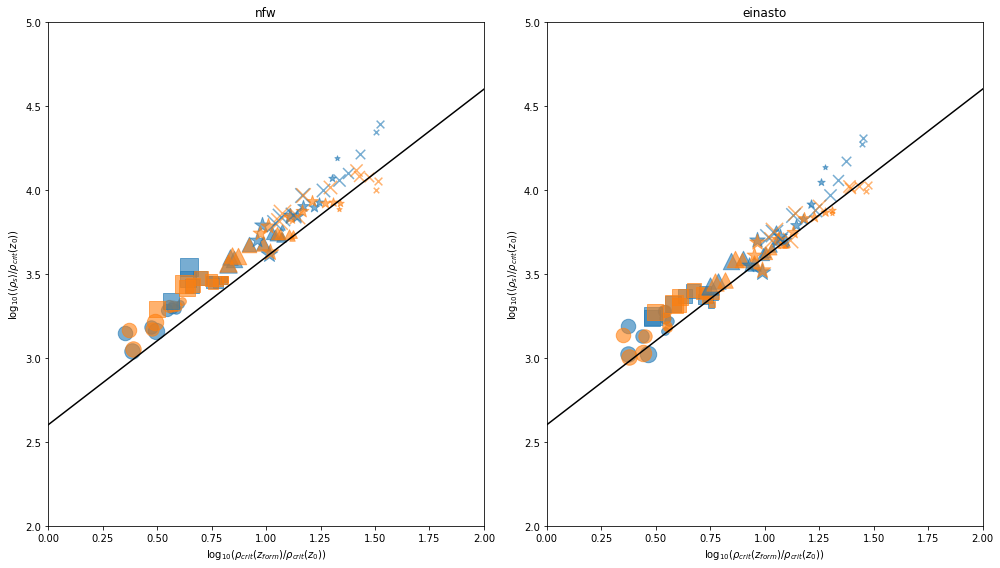

In [34]:
# d = read()

# fig, ax = plt.subplots(1, 2, figsize=(14, 8))

# for i,p in enumerate(['nfw', 'einasto']):
#     plot(ax[i], d[d['profile'] == p])
#     ax[i].set_title(p)

# fig.tight_layout()

- plot c-m for different bins, use theoretical values of c to plot NFW profiles (compare to fits)
    - x-y: r-M, values from different mass bins, as well as analytical curve (steeper?)
    - compare concentrations of profiles of different mass bins on the  same plot
- fit to individual profiles & average later
- Tuesday 1pm

In [102]:
# import seaborn as sns
# sns.FacetGrid(d, col='profile', hue='g', size=6)\
#     .map(plt.scatter, 'rho_f', 'rho_s', s=d['bin']*10)
# plt.plot([0.0, 2.0], np.log10(400.0 * np.power(10.0, np.array([0.0, 2.0]))), 'k-')